# MNIST Image Classification with TensorFlow on Cloud AI Platform

This notebook demonstrates how to implement different image models on MNIST using the [tf.keras API](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras).

## Learning Objectives
1. Understand how to build a Dense Neural Network (DNN) for image classification
2. Understand how to use dropout (DNN) for image classification
3. Understand how to use Convolutional Neural Networks (CNN)
4. Know how to deploy and use an image classification model using Google Cloud's [AI Platform](https://cloud.google.com/ai-platform/)

Each learning objective will correspond to a __#TODO__ in the [student lab notebook](training-data-analyst/courses/machine_learning/deepdive2/image_classification/labs/2_mnist_models.ipynb) -- try to complete that notebook first before reviewing this solution notebook.

First things first. Configure the parameters below to match your own Google Cloud project details.

In [1]:
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [2]:
# Here we'll show the currently installed version of TensorFlow
import tensorflow as tf
print(tf.__version__)

2.5.0


In [15]:
from datetime import datetime
import os

PROJECT = "qwiklabs-gcp-00-188beb26468b"  # REPLACE WITH YOUR PROJECT ID
BUCKET = "qwiklabs-gcp-00-188beb26468b"  # REPLACE WITH YOUR BUCKET NAME
REGION = "us-central1"  # REPLACE WITH YOUR BUCKET REGION e.g. us-central1
MODEL_TYPE = "cnn"  # "linear", "cnn", "dnn_dropout", or "dnn"

# Do not change these
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["MODEL_TYPE"] = MODEL_TYPE
os.environ["TFVERSION"] = "2.5"  # Tensorflow  version
os.environ["IMAGE_URI"] = os.path.join("gcr.io", PROJECT, "mnist_models_1")

## Building a dynamic model

In the previous notebook, <a href="mnist_linear.ipynb">mnist_linear.ipynb</a>, we ran our code directly from the notebook. In order to run it on the AI Platform, it needs to be packaged as a python module.

The boilerplate structure for this module has already been set up in the folder `mnist_models`. The module lives in the sub-folder, `trainer`, and is designated as a python package with the empty `__init__.py` (`mnist_models/trainer/__init__.py`) file. It still needs the model and a trainer to run it, so let's make them.

Let's start with the trainer file first. This file parses command line arguments to feed into the model.

In [9]:
%%writefile mnist_models/trainer/task.py
import argparse
import json
import os
import sys

from . import model


def _parse_arguments(argv):
    """Parses command-line arguments."""
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--model_type',
        help='Which model type to use',
        type=str, default='linear')
    parser.add_argument(
        '--epochs',
        help='The number of epochs to train',
        type=int, default=10)
    parser.add_argument(
        '--steps_per_epoch',
        help='The number of steps per epoch to train',
        type=int, default=100)
    parser.add_argument(
        '--job-dir',
        help='Directory where to save the given model',
        type=str, default='mnist_models/')
    return parser.parse_known_args(argv)


def main():
    """Parses command line arguments and kicks off model training."""
    args = _parse_arguments(sys.argv[1:])[0]

    # Configure path for hyperparameter tuning.
    trial_id = json.loads(
        os.environ.get('TF_CONFIG', '{}')).get('task', {}).get('trial', '')
    output_path = args.job_dir if not trial_id else args.job_dir + '/'

    model_layers = model.get_layers(args.model_type)
    image_model = model.build_model(model_layers, args.job_dir)
    model_history = model.train_and_evaluate(
        image_model, args.epochs, args.steps_per_epoch, args.job_dir)


if __name__ == '__main__':
    main()


Writing mnist_models/trainer/task.py


Next, let's group non-model functions into a util file to keep the model file simple. We'll copy over the `scale` and `load_dataset` functions from the previous lab.

In [4]:
%%writefile mnist_models/trainer/util.py
import tensorflow as tf


def scale(image, label):
    """Scales images from a 0-255 int range to a 0-1 float range"""
    image = tf.cast(image, tf.float32)
    image /= 255
    image = tf.expand_dims(image, -1)
    return image, label


def load_dataset(
        data, training=True, buffer_size=5000, batch_size=100, nclasses=10):
    """Loads MNIST dataset into a tf.data.Dataset"""
    (x_train, y_train), (x_test, y_test) = data
    x = x_train if training else x_test
    y = y_train if training else y_test
    # One-hot encode the classes
    y = tf.keras.utils.to_categorical(y, nclasses)
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(scale).batch(batch_size)
    if training:
        dataset = dataset.shuffle(buffer_size).repeat()
    return dataset


Writing mnist_models/trainer/util.py


Finally, let's code the models! The [tf.keras API](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras) accepts an array of [layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers) into a [model object](https://www.tensorflow.org/api_docs/python/tf/keras/Model), so we can create a dictionary of layers based on the different model types we want to use. The below file has two functions: `get_layers` and `create_and_train_model`. We will build the structure of our model in `get_layers`. Last but not least, we'll copy over the training code from the previous lab into `train_and_evaluate`.

**TODO 1**: Define the Keras layers for a DNN model   
**TODO 2**: Define the Keras layers for a dropout model  
**TODO 3**: Define the Keras layers for a CNN model  

Hint: These models progressively build on each other. Look at the imported `tensorflow.keras.layers` modules and the default values for the variables defined in `get_layers` for guidance.

In [5]:
%%writefile mnist_models/trainer/model.py
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import (
    Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Softmax)

from . import util


# Image Variables
WIDTH = 28
HEIGHT = 28


def get_layers(
        model_type,
        nclasses=10,
        hidden_layer_1_neurons=400,
        hidden_layer_2_neurons=100,
        dropout_rate=0.25,
        num_filters_1=64,
        kernel_size_1=3,
        pooling_size_1=2,
        num_filters_2=32,
        kernel_size_2=3,
        pooling_size_2=2):
    """Constructs layers for a keras model based on a dict of model types."""
    model_layers = {
        'linear': [
            Flatten(),
            Dense(nclasses),
            Softmax()
        ],
        'dnn': [
            Flatten(),
            Dense(hidden_layer_1_neurons, activation='relu'),
            Dense(hidden_layer_2_neurons, activation='relu'),
            Dense(nclasses),
            Softmax()
        ],
        'dnn_dropout': [
            Flatten(),
            Dense(hidden_layer_1_neurons, activation='relu'),
            Dense(hidden_layer_2_neurons, activation='relu'),
            Dropout(dropout_rate),
            Dense(nclasses),
            Softmax()
        ],
        'cnn': [
            Conv2D(num_filters_1, kernel_size=kernel_size_1,
                   activation='relu', input_shape=(WIDTH, HEIGHT, 1)),
            MaxPooling2D(pooling_size_1),
            Conv2D(num_filters_2, kernel_size=kernel_size_2,
                   activation='relu'),
            MaxPooling2D(pooling_size_2),
            Flatten(),
            Dense(hidden_layer_1_neurons, activation='relu'),
            Dense(hidden_layer_2_neurons, activation='relu'),
            Dropout(dropout_rate),
            Dense(nclasses),
            Softmax()
        ]
    }
    return model_layers[model_type]


def build_model(layers, output_dir):
    """Compiles keras model for image classification."""
    model = Sequential(layers)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def train_and_evaluate(model, num_epochs, steps_per_epoch, output_dir):
    """Compiles keras model and loads data into it for training."""
    mnist = tf.keras.datasets.mnist.load_data()
    train_data = util.load_dataset(mnist)
    validation_data = util.load_dataset(mnist, training=False)

    callbacks = []
    if output_dir:
        tensorboard_callback = TensorBoard(log_dir=output_dir)
        callbacks = [tensorboard_callback]

    history = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
        verbose=2,
        callbacks=callbacks)

    if output_dir:
        export_path = os.path.join(output_dir, 'keras_export')
        model.save(export_path, save_format='tf')

    return history


Writing mnist_models/trainer/model.py


## Local Training

With everything set up, let's run locally to test the code. Some of the previous tests have been copied over into a testing script `mnist_models/trainer/test.py` to make sure the model still passes our previous checks. On `line 13`, you can specify which model types you would like to check. `line 14` and `line 15` has the number of epochs and steps per epoch respectively.

Moment of truth! Run the code below to check your models against the unit tests. If you see "OK" at the end when it's finished running, congrats! You've passed the tests!

In [6]:
!python3 -m mnist_models.trainer.test

11493376/11490434 [==============================] - 0s 0us/step
2021-08-13 06:25:29.196991: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2021-08-13 06:25:29.331664: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-13 06:25:29.338746: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2200150000 Hz
..
*** Building model for linear ***

Epoch 1/10
100/100 - 5s - loss: 1.3137 - accuracy: 0.6783 - val_loss: 0.7810 - val_accuracy: 0.8440
Epoch 2/10
100/100 - 1s - loss: 0.6693 - accuracy: 0.8479 - val_loss: 0.5503 - val_accuracy: 0.8782
Epoch 3/10
100/100 - 1s - loss: 0.5243 - accuracy: 0.8760 - val_loss: 0.4635 - val_accuracy: 0.8885
Epoch 4/10
100/100 - 1s - loss: 0.4689 - accuracy: 0.8806 - val_loss: 0.4170 - val_accuracy: 0.8962
Epoch 5/10
100/100 - 1

Now that we know that our models are working as expected, let's run it on the [Google Cloud AI Platform](https://cloud.google.com/ml-engine/docs/). We can run it as a python module locally first using the command line.

The below cell transfers some of our variables to the command line as well as create a job directory including a timestamp.

In [16]:
current_time = datetime.now().strftime("%y%m%d_%H%M%S")
model_type = 'cnn' # "linear", "cnn", "dnn_dropout", or "dnn"

os.environ["MODEL_TYPE"] = model_type
os.environ["JOB_DIR"] = "mnist_models/models/{}_{}/".format(
    model_type, current_time)

The cell below runs the local version of the code. The epochs and steps_per_epoch flag can be changed to run for longer or shorter, as defined in our `mnist_models/trainer/task.py` file.

In [17]:
%%bash
python3 -m mnist_models.trainer.task \
    --job-dir=$JOB_DIR \
    --epochs=5 \
    --steps_per_epoch=50 \
    --model_type=$MODEL_TYPE

Epoch 1/5
50/50 - 9s - loss: 0.9820 - accuracy: 0.6936 - val_loss: 0.2927 - val_accuracy: 0.9156
Epoch 2/5
50/50 - 5s - loss: 0.3049 - accuracy: 0.9126 - val_loss: 0.1737 - val_accuracy: 0.9479
Epoch 3/5
50/50 - 5s - loss: 0.1840 - accuracy: 0.9478 - val_loss: 0.1244 - val_accuracy: 0.9614
Epoch 4/5
50/50 - 5s - loss: 0.1752 - accuracy: 0.9474 - val_loss: 0.1103 - val_accuracy: 0.9639
Epoch 5/5
50/50 - 5s - loss: 0.1415 - accuracy: 0.9564 - val_loss: 0.0904 - val_accuracy: 0.9726


2021-08-13 06:35:34.475704: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2021-08-13 06:35:34.955905: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-13 06:35:34.955951: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-08-13 06:35:34.955992: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-08-13 06:35:35.724748: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-13 06:35:35.726952: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2200150000 Hz
2021-08-13 06:35:38.942929: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-13 06:35:38.943333: I tensorflow/core/profiler/lib/profiler_sessi

## Training on the cloud

Since we're using an unreleased version of TensorFlow on AI Platform, we can instead use a [Deep Learning Container](https://cloud.google.com/ai-platform/deep-learning-containers/docs/overview) in order to take advantage of libraries and applications not normally packaged with AI Platform. Below is a simple [Dockerlife](https://docs.docker.com/engine/reference/builder/) which copies our code to be used in a TF2 environment.

In [18]:
%%writefile mnist_models/Dockerfile
FROM gcr.io/deeplearning-platform-release/tf2-cpu
COPY mnist_models/trainer /mnist_models/trainer
ENTRYPOINT ["python3", "-m", "mnist_models.trainer.task"]

Overwriting mnist_models/Dockerfile


The below command builds the image and ships it off to Google Cloud so it can be used for AI Platform. When built, it will show up [here](http://console.cloud.google.com/gcr) with the name `mnist_models`. ([Click here](https://console.cloud.google.com/cloud-build) to enable Cloud Build)

In [20]:
!docker build -f mnist_models/Dockerfile -t $IMAGE_URI ./

Sending build context to Docker daemon  11.15MB
Step 1/3 : FROM gcr.io/deeplearning-platform-release/tf2-cpu
 ---> 41ad127133f5
Step 2/3 : COPY mnist_models/trainer /mnist_models/trainer
 ---> Using cache
 ---> dae6e40b32fa
Step 3/3 : ENTRYPOINT ["python3", "-m", "mnist_models.trainer.task"]
 ---> Using cache
 ---> 392a569357be
Successfully built 392a569357be
Successfully tagged gcr.io/qwiklabs-gcp-00-188beb26468b/mnist_models_1:latest


In [21]:
!docker push $IMAGE_URI

Using default tag: latest
The push refers to repository [gcr.io/qwiklabs-gcp-00-188beb26468b/mnist_models_1]

7edfa297: Preparing 
8657c8ea: Preparing 
f3f0bc61: Preparing 
84cdcd53: Preparing 
8fe462d3: Preparing 
582c8414: Preparing 
2fcdb550: Preparing 
fcf5cda1: Preparing 
a6645274: Preparing 
3adcd9d2: Preparing 
4eca1563: Preparing 
b4bc0668: Preparing 
c73dfc63: Preparing 
8e4795f1: Preparing 
9d96e302: Preparing 
bf18a086: Preparing 
88b681cd: Preparing 
a46b9ff5: Preparing 
e6413c69: Preparing 
e6413c69: Mounted from deeplearning-platform-release/tf2-cpu latest: digest: sha256:faa0245a615164cab5af7b60d43469a9eeda78ec99eabb6fc396b5b6a7171d11 size: 4506


Finally, we can kickoff the [AI Platform training job](https://cloud.google.com/sdk/gcloud/reference/ai-platform/jobs/submit/training). We can pass in our docker image using the `master-image-uri` flag.

In [22]:
current_time = datetime.now().strftime("%y%m%d_%H%M%S")
model_type = 'cnn' # "linear", "cnn", "dnn_dropout", or "dnn"

os.environ["MODEL_TYPE"] = model_type
os.environ["JOB_DIR"] = "gs://{}/mnist_{}_{}/".format(
    BUCKET, model_type, current_time)
os.environ["JOB_NAME"] = "mnist_{}_{}".format(
    model_type, current_time)

In [23]:
%%bash
echo $JOB_DIR $REGION $JOB_NAME
gcloud ai-platform jobs submit training $JOB_NAME \
    --staging-bucket=gs://$BUCKET \
    --region=$REGION \
    --master-image-uri=$IMAGE_URI \
    --scale-tier=BASIC_GPU \
    --job-dir=$JOB_DIR \
    -- \
    --model_type=$MODEL_TYPE

gs://qwiklabs-gcp-00-188beb26468b/mnist_cnn_210813_063713/ us-central1 mnist_cnn_210813_063713
jobId: mnist_cnn_210813_063713
state: QUEUED


Job [mnist_cnn_210813_063713] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe mnist_cnn_210813_063713

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs mnist_cnn_210813_063713


Can't wait to see the results? Run the code below and copy the output into the [Google Cloud Shell](https://console.cloud.google.com/home/dashboard?cloudshell=true) to follow.

## Deploying and predicting with model

Once you have a model you're proud of, let's deploy it! All we need to do is give AI Platform the location of the model. Below uses the keras export path of the previous job, but `${JOB_DIR}keras_export/` can always be changed to a different path.

Uncomment the delete commands below if you are getting an "already exists error" and want to deploy a new model.

In [31]:
%%bash
MODEL_NAME="mnist"
MODEL_VERSION=${MODEL_TYPE}
MODEL_LOCATION=${JOB_DIR}keras_export/
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"
#yes | gcloud ai-platform versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#yes | gcloud ai-platform models delete ${MODEL_NAME}
gcloud config set ai_platform/region global
gcloud ai-platform models create ${MODEL_NAME} --regions $REGION

Deleting and deploying mnist cnn from gs://qwiklabs-gcp-00-188beb26468b/mnist_cnn_210813_063713/keras_export/ ... this will take a few minutes


Updated property [ai_platform/region].
Using endpoint [https://ml.googleapis.com/]
Created ai platform model [projects/qwiklabs-gcp-00-188beb26468b/models/mnist].


In [35]:
%%bash
MODEL_NAME="mnist"
MODEL_VERSION=${MODEL_TYPE}
MODEL_LOCATION=${JOB_DIR}keras_export/
gcloud ai-platform versions create ${MODEL_VERSION} \
    --model ${MODEL_NAME} \
    --origin ${MODEL_LOCATION} \
    --framework tensorflow \
    --runtime-version=2.5

Using endpoint [https://ml.googleapis.com/]
Creating version (this might take a few minutes)......
...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................done.


To predict with the model, let's take one of the example images.

**TODO 4**: Write a `.json` file with image data to send to an AI Platform deployed model

In [45]:
import json, codecs
import tensorflow as tf
import matplotlib.pyplot as plt
from mnist_models.trainer import util

HEIGHT = 28
WIDTH = 28
IMGNO = 12

mnist = tf.keras.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist
test_image = x_test[IMGNO:IMGNO+2]

jsondata = test_image.reshape(2,HEIGHT, WIDTH, 1).tolist()
json.dump(jsondata, codecs.open("test.json", "w", encoding = "utf-8"))
# plt.imshow(test_image.reshape(HEIGHT, WIDTH));

In [46]:
test_image.reshape(2,HEIGHT, WIDTH, 1).shape

(2, 28, 28, 1)

In [40]:
test_image.reshape(HEIGHT, WIDTH, 1).shape

(28, 28, 1)

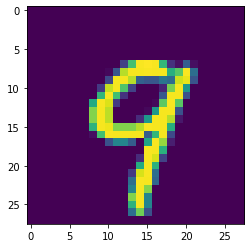

In [30]:
plt.imshow(test_image[0].reshape(HEIGHT, WIDTH));

Finally, we can send it to the prediction service. The output will have a 1 in the index of the corresponding digit it is predicting. Congrats! You've completed the lab!

In [44]:
%%bash
gcloud ai-platform predict \
    --model=mnist \
    --version=${MODEL_TYPE} \
    --json-instances=./test.json

{
  "error": "Prediction failed: Error during model execution: <_MultiThreadedRendezvous of RPC that terminated with:\n\tstatus = StatusCode.INVALID_ARGUMENT\n\tdetails = \"input must be 4-dimensional[1,1,2,28,28,1]\n\t [[{{node sequential/conv2d/Relu}}]]\"\n\tdebug_error_string = \"{\"created\":\"@1628838434.038406056\",\"description\":\"Error received from peer ipv4:127.0.0.1:8081\",\"file\":\"src/core/lib/surface/call.cc\",\"file_line\":1062,\"grpc_message\":\"input must be 4-dimensional[1,1,2,28,28,1]\\n\\t [[{{node sequential/conv2d/Relu}}]]\",\"grpc_status\":3}\"\n>"
}


Using endpoint [https://ml.googleapis.com/]


Copyright 2021 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.